# LOAD LIBRARIES

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, probplot

# CONFIGURATION

In [24]:
START_DATE, END_DATE = '2022-09-01', '2023-10-05'
TIME_RESOLUTION = '24'
TARGET = f'flux_n2o_qcf0'

# LOAD DATA

In [25]:
data_main = pd.read_csv(f'../data/processed/DRIVERS_dataset_{TIME_RESOLUTION}h.csv', low_memory=False)
data_main['timestamp_middle'] = pd.to_datetime(data_main['timestamp_middle'])
data_main.set_index('timestamp_middle', inplace=True)
data_main = data_main.loc[START_DATE:END_DATE]

# FIGURE

WFPS ≤ 55%
$y = -0.03x +0.63$
R2=0.30, p=8.577386856174002e-05
55% < WFPS < 70%
$y = -0.04x +1.36$
R2=0.61, p=6.235464014444427e-15
WFPS ≥ 70%
$y = -0.18x +3.42$
R2=0.71, p=4.252084615429979e-05


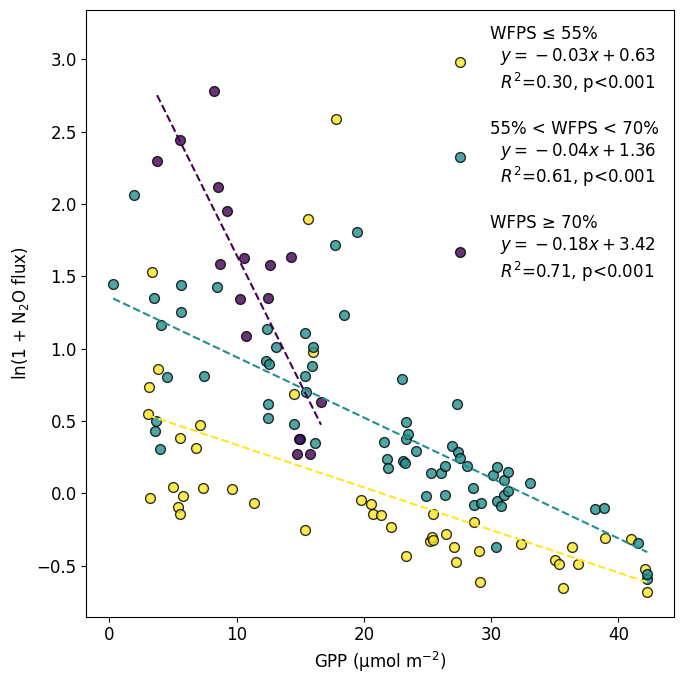

In [26]:
start_date = '2023-03-01'
end_date   = '2023-07-15'
indat = data_main.loc[start_date:end_date].copy()

# Remove rows where either TARGET, GPP or WFPS is NaN
X_col    = 'flux_gpp_roll48hsum'
WFPS_col = 'wfps_0.3_roll48hmean'

indat = indat.dropna(subset=[X_col, TARGET, WFPS_col])
indat = indat.sort_values(X_col)

x = indat[X_col].values
y = np.log1p(indat[TARGET])  # ln(1 + N2O flux)

# Define dry / medium / wet 
dry_thr = 55
wet_thr = 70
WFPS    = indat[WFPS_col]
mask_dry    = WFPS <= dry_thr
mask_medium = (WFPS > dry_thr) & (WFPS <  wet_thr)
mask_wet    = WFPS >= wet_thr

# Set up groups with class indices
groups = {
    f"WFPS ≤ {dry_thr}%":         (mask_dry,    0),
    f"{dry_thr}% < WFPS < {wet_thr}%": (mask_medium, 1),
    f"WFPS ≥ {wet_thr}%":         (mask_wet,    2),
}

# Class index per point for coloring
class_ids = np.full(len(indat), np.nan)
for _, (mask, idx) in groups.items():
    class_ids[mask.values] = idx  # .values to align masks

# Use viridis reversed with 3 discrete colors
color_map = plt.get_cmap("viridis_r", 3)

# Helper to format p-values
def format_p(p):
    if p < 0.001:
        return "<0.001"
    elif p < 0.05:
        return "<0.05"
    else:
        return f"={p:.2f}"
    
########## Start plotting ##########
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7, 7))

legend_handles = []
legend_labels  = []

for name, (mask, idx) in groups.items():
    xg = x[mask]
    yg = y[mask]
    color = color_map(idx)

    # Regression
    slope, intercept, r, p, _ = linregress(xg, yg)
    xline = np.linspace(xg.min(), xg.max(), 100)
    yline = slope * xline + intercept

    # Scatter for this class
    sc = plt.scatter(
        xg, yg,
        color=color,
        edgecolors="k",
        alpha=0.8,
        s=50,
    )

    # Regression line
    plt.plot(xline, yline, color=color, linestyle='dashed')

    # Build multi-line legend label
    eq_text = rf"$y = {slope:.2f}x {intercept:+.2f}$"
    label = (
        f"{name}\n"
        f"  {eq_text}\n"
        f"  $R^2$={r**2:.2f}, p{format_p(p)}"
    )

    legend_handles.append(sc)
    legend_labels.append(label)

    # (optional) print to console
    print(f"{name}\n{eq_text}\nR2={r**2:.2f}, p={p}")

# Labels and axis formatting
plt.ylim(top=y.max() * 1.2)
plt.xlabel("GPP (µmol m$^{-2}$)")
plt.ylabel("ln(1 + N$_{2}$O flux)")

# Legend with stats under each WFPS class
plt.legend(
    handles=legend_handles,
    labels=legend_labels,
    frameon=False,
    loc='upper right',
    bbox_to_anchor=(1, 1),
    labelspacing=1.5
)

plt.tight_layout()
plt.savefig('../figures/GPP_vs_N2O.png', dpi=300, bbox_inches="tight")
plt.show()